In [2]:
import torch
from torch_scatter import scatter_mean
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import networkx as nx
import os
import pickle
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from methods import mcmc_community, mmca_community
from methods.utils import graph_dynamic

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# ---------------初始数据-----------------------------

# 导入默认参数
file_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'parameters/community_data_1.pkl')
with open(file_path, 'rb') as f:
    init_data = pickle.load(f)

epi_paras = torch.tensor(init_data['epi_paras'], dtype=torch.float32).to(device)
soc_paras = torch.tensor(init_data['soc_paras'], dtype=torch.float32).to(device)
features_state = torch.tensor(init_data['init_state'], dtype=torch.float32).to(device)
P_rows, P_cols = init_data['P_matrix'].nonzero()
P_edge_index = torch.tensor(np.array([P_rows, P_cols]), dtype=torch.long).to(device)
communities = init_data['communities']
P_community = init_data['P_community']
P_G = init_data['P_G']

I_rows, I_cols = init_data['I_matrix'].nonzero()
I_edge_index = torch.tensor(np.array([I_rows, I_cols]), dtype=torch.long).to(device)

# # # ---------------初始数据-----------------------------
node_num =  features_state.shape[0]
time_scale = 1000

In [3]:
para_len = 100
soc_paras_mcmc = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_mcmc = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 
features_state_tensor_mcmc = features_state.unsqueeze(0).repeat(para_len, 1, 1).to(device)

mcmc = mcmc_community.MCMC(para_len, node_num, device)
mcmc_features_times, _ = graph_dynamic(time_scale, mcmc, features_state_tensor_mcmc.clone(), epi_paras_mcmc,\
                                        soc_paras_mcmc, P_edge_index, I_edge_index, communities, device)

In [4]:
para_len = 1
soc_paras_mmca = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_mmca = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 
features_state_tensor_mmca = features_state.unsqueeze(0).repeat(para_len, 1, 1).to(device)

mmca = mmca_community.MMCA(device)
mmca_features_times, _ = graph_dynamic(time_scale, mmca, features_state_tensor_mmca.clone(), epi_paras_mmca,\
                                        soc_paras_mmca, P_edge_index, I_edge_index, communities, device)

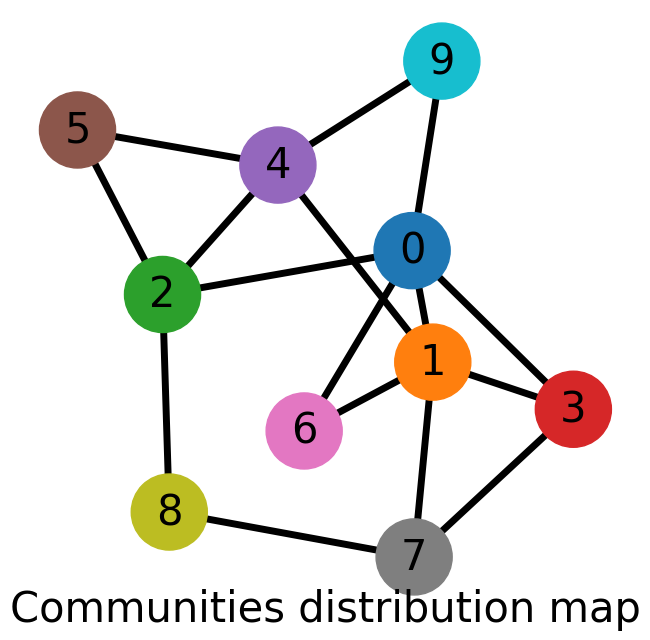

In [4]:
# 可视化社区图
plt.figure(figsize=(6, 6))
# community_pos = nx.spring_layout(community_graph, seed=1)  # 社区图的位置
community_pos = nx.kamada_kawai_layout(P_community)
nx.draw(P_community, community_pos, node_color=range(len(P_community)), cmap='tab10', node_size=3000, width=5,
         with_labels=True, font_size=30, font_color='black' )
plt.text(0.5, 0, f"Communities distribution map", 
         fontsize=30, ha='center', va='center', transform=plt.gca().transAxes)
# plt.show()
plt.savefig(f'../figs/Diffusion/Community1/c0.svg', bbox_inches='tight')
plt.savefig(f'../figs/Diffusion/Community1/c0.png', dpi=600, bbox_inches='tight')


In [5]:
# # 根据社区图的位置为节点图分配位置
# node_pos = {}
# for node, community in enumerate(communities):
#     # 在社区位置的基础上添加随机偏移
#     offset = np.random.normal(0.1, 0.13, size=2)  # 随机偏移
#     node_pos[node] = community_pos[community] + offset
# # 为每个社区计算布局
from collections import defaultdict
node_pos = {}
community_nodes = defaultdict(list)
# 将节点按社区分组
for node, community in enumerate(communities):
    community_nodes[community].append(node)
# 为每个社区计算布局
for community, nodes in community_nodes.items():
    subgraph = P_G.subgraph(nodes)  # 提取社区子图
    subgraph_pos = nx.spring_layout(subgraph, k=0.5, iterations=100)  # 社区内布局
    if community == 7:
        k=0.5
    else:
        k=0.5
    for node in nodes:
        node_pos[node] = k*subgraph_pos[node] + community_pos[community]  # 映射到全局布局


c:\Users\95406\.conda\envs\stablebaseline3\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


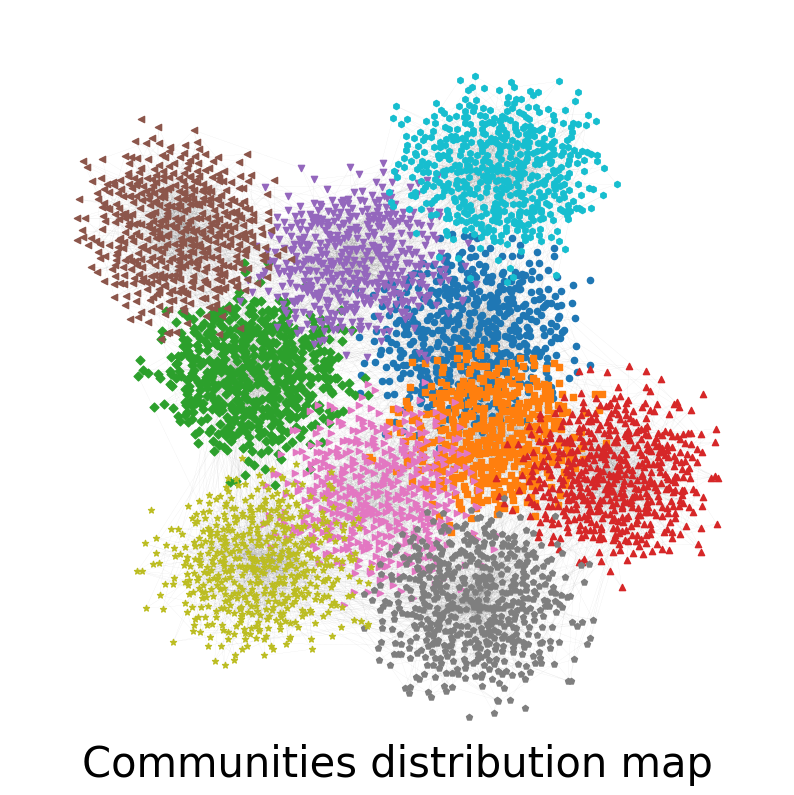

In [6]:
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', '+', 'X', 'd']
# 可视化生成的节点图
plt.figure(figsize=(10, 10))
# 绘制节点，为每个社区分配不同的 marker
for i, community in enumerate(set(communities)):
    nodes_in_community = [node for node, comm in zip(P_G.nodes(), communities) if comm == community]
    nx.draw_networkx_nodes(P_G, node_pos, nodelist=nodes_in_community, 
                           node_color=plt.cm.tab10(i), node_size=20, 
                           node_shape=markers[i % len(markers)]) 
nx.draw_networkx_edges(P_G, node_pos, width=0.015)
# nx.draw(P_G, node_pos, node_color=communities, cmap='tab10', node_size=20, width=0.03)
plt.text(0.5, 0.02, f"Communities distribution map", 
         fontsize=30, ha='center', va='center', transform=plt.gca().transAxes)
legend_elements = [Line2D([0], [0], marker=markers[i % len(markers)], color='w', label=f'Com {i}', 
                          markerfacecolor=plt.cm.tab10(i), markersize=10) for i in range(len(set(communities)))]
# plt.legend(handles=legend_elements, loc='upper right',fontsize=15)
plt.axis('off')
# plt.show()
plt.savefig(f'../figs/Diffusion/Community1/c1.svg', bbox_inches='tight')
plt.savefig(f'../figs/Diffusion/Community1/c1.png', dpi=600, bbox_inches='tight')

In [28]:
time_index = 10
features_mcmc = mcmc_features_times.squeeze(0)[time_index,...]
features_mmca = mmca_features_times.squeeze(0)[time_index,...]

communities_cpu = torch.tensor(communities)
communities_features_mcmc = scatter_mean(torch.sum(features_mcmc[:,[2,3,4]],dim=1), communities_cpu, dim=0) 
mcmc_mean = torch.mean(features_mcmc[:, [2, 3, 4]].sum(dim=1)).unsqueeze(0)
communities_features_mcmc = torch.cat((communities_features_mcmc, mcmc_mean))

communities_features_mmca = scatter_mean(torch.sum(features_mmca[:,[2,3,4]],dim=1), communities_cpu, dim=0) 
mmca_mean = torch.mean(features_mmca[:, [2, 3, 4]].sum(dim=1)).unsqueeze(0)
communities_features_mmca = torch.cat((communities_features_mmca, mmca_mean))
print(communities_features_mcmc)
print(communities_features_mmca)

tensor([0.3920, 0.3890, 0.3753, 0.3740, 0.3742, 0.3568, 0.3822, 0.3767, 0.3665,
        0.3743, 0.3760])
tensor([0.4136, 0.4124, 0.4059, 0.4011, 0.4024, 0.3925, 0.3984, 0.4030, 0.3937,
        0.3994, 0.4022])


tensor(0.3760)


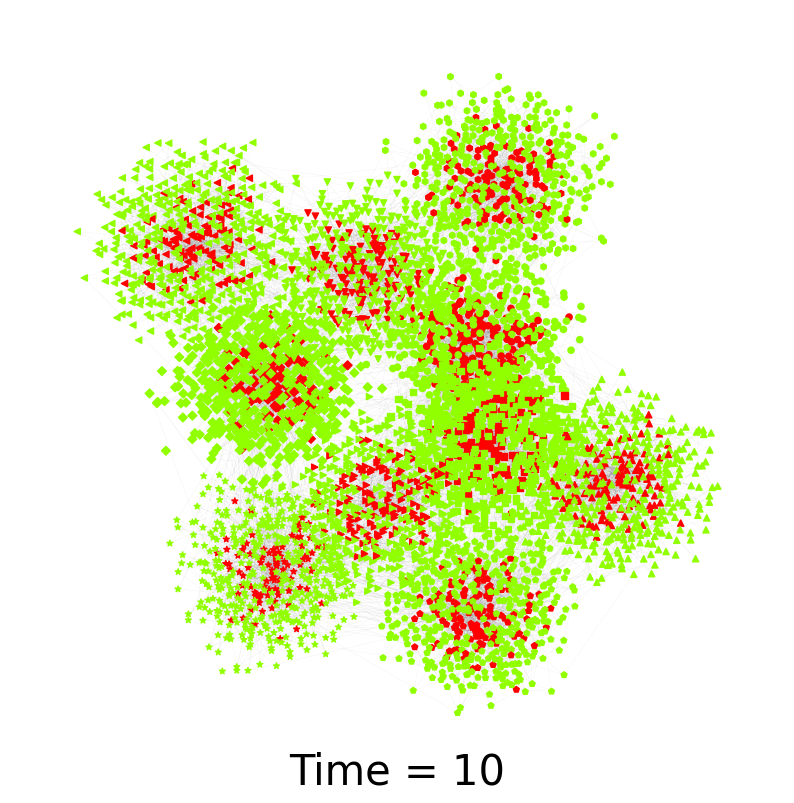

In [29]:
# custom_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF']
custom_colors = ["#91FF00",'#FF0000']
custom_cmap = mcolors.ListedColormap(custom_colors)
# 可视化生成的节点图
node_color = torch.sum(features_mcmc[:,[2,3,4]],dim=1)
print(torch.mean(node_color))
plt.figure(figsize=(10, 10))
# 绘制节点，为每个社区分配不同的 marker
for i, community in enumerate(set(communities)):
    nodes_in_community = [node for node, comm in zip(P_G.nodes(), communities) if comm == community]
    nx.draw_networkx_nodes(P_G, node_pos, nodelist=nodes_in_community, 
                           node_color=node_color[nodes_in_community], cmap=custom_cmap, node_size=20, 
                           node_shape=markers[i % len(markers)]) 
nx.draw_networkx_edges(P_G, node_pos, width=0.015)
# nx.draw(P_G, node_pos, node_color=node_color, cmap=custom_cmap, node_size=20, width=0.03)
plt.text(0.5, 0.01, f"Time = {time_index}", 
         fontsize=30, ha='center', va='center', transform=plt.gca().transAxes)
# plt.title("Community-based BA Model with Community Layout")
plt.axis('off')
# plt.show()
plt.savefig(f'../figs/Diffusion/Community1/t{time_index}.svg', bbox_inches='tight')
plt.savefig(f'../figs/Diffusion/Community1/t{time_index}.png', dpi=600, bbox_inches='tight')

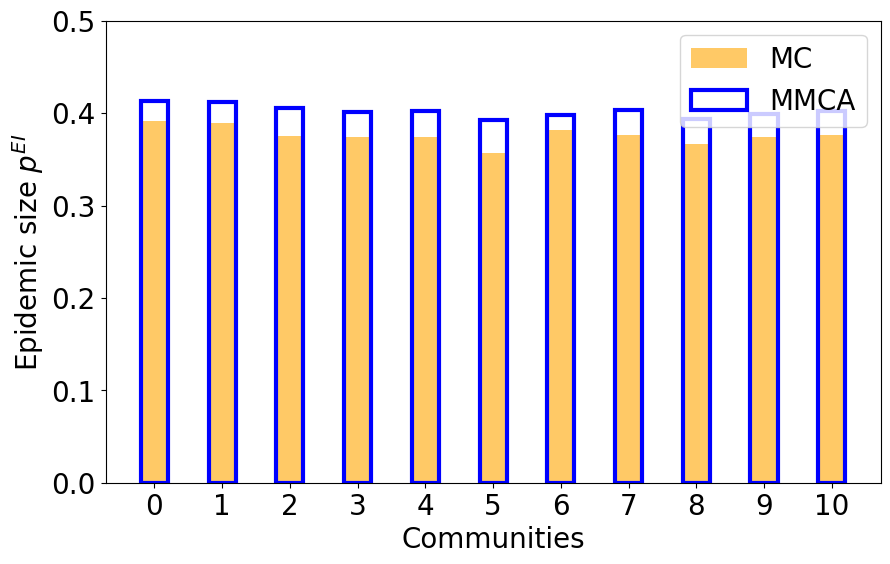

In [30]:
# 数据
data1 = communities_features_mcmc
data2 = communities_features_mmca
# x轴标签
x_labels = [f'{i}' for i in range(len(data1))]

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制第二个系列（用实体表示）
plt.bar(x_labels, data1, width=0.4, color='orange', alpha=0.6, label='MC')
# 绘制第一个系列（用框表示）
plt.bar(x_labels, data2 , width=0.4, color='none', edgecolor='blue', linewidth=3, label='MMCA')

# 添加标题和标签
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Communities', fontsize=20)
plt.ylim(0, 0.5) 
plt.ylabel(r'Epidemic size $p^{EI}$', fontsize=20)
plt.legend(fontsize=20)

# 显示图形
# plt.show()
plt.savefig(f'../figs/Diffusion/Community1/bar{time_index}.svg', bbox_inches='tight')